In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
vix_data = yf.download('^VIX', start='2008-01-01')
vix_data['VIX_close'] = vix_data['Adj Close']

vol_df = pd.read_csv('volatility_df.csv', 
                     parse_dates=['Date'], index_col='Date')

volatility_df = pd.merge_asof(vol_df, vix_data['VIX_close'], left_index=True, right_index=True, direction='nearest')
volatility_df = volatility_df.set_index(vol_df.index)
volatility_df.isna().sum()

[*********************100%%**********************]  1 of 1 completed


Recovered_vol                    0
Risk_premium                     0
Risk_preference                  0
Risk_neutral_skewness            0
Risk_neutral_kurtosis            0
Recovered_skewness               0
Recovered_kurtosis               0
USA_10_y_treasuries              0
Effective_Fed_Funds_Rate_true    0
Consumer_Price_Index_true        0
Producer_Price_Index_true        0
Unemployment_Rate_true           0
GDP_true                         0
Industrial_Production_true       0
Mortgage_Rates_true              0
Realized_Volatility              0
VIX_close                        0
dtype: int64

In [3]:
volatility_df = volatility_df[['Recovered_vol', 'Realized_Volatility']]

volatility_df = volatility_df.replace([0], 1e-6)

volatility_df = volatility_df / volatility_df.shift(1) - 1

lag = -5
volatility_df[f'Realized_Volatility_(t+{abs(lag)})'] = volatility_df['Realized_Volatility'].shift(lag)
volatility_df = volatility_df.dropna()
volatility_df.drop('Realized_Volatility', axis=1, inplace=True)
print(len(volatility_df))
volatility_df.head(10)

3357


,Recovered_vol,Realized_Volatility_(t+5)
Date,,
2010-01-05,-0.024188,0.031692
2010-01-06,0.001425,0.029962
2010-01-07,0.007015,-0.022161
2010-01-08,0.030061,0.046408
2010-01-11,0.030583,0.073188
2010-01-12,-0.037054,-0.011969
2010-01-13,0.161288,0.137014
2010-01-14,0.012751,0.125819
2010-01-15,-0.231002,0.002256


In [4]:
# Стандартизация, нормализация, замена выбросов медианой

values_clear = volatility_df.copy()

train_size = int(len(values_clear) * 0.7)
val_size = int(len(values_clear) * 0.15)
test_size = len(values_clear) - train_size - val_size

train = values_clear.iloc[:train_size]
val = values_clear.iloc[train_size:train_size + val_size]
test = values_clear.iloc[train_size + val_size:]

# Обучаем стандартизатор, нормализатор и изолейшн форест на тренировочных данных
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(train)
train_transformed = transformer.transform(train)

scaler = MinMaxScaler(feature_range=(1e-6, 1))
scaler.fit(train_transformed)
train_scaled = scaler.transform(train_transformed)

isolation_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42) # 0.01
isolation_forest.fit(train_scaled)

normalizer = Normalizer()
normalizer.fit(train_scaled)

# Применяем стандартизатор, нормализатор и изолейшн форест на тренировочных, валидационных и тестовых данных
train_isolation_forest = isolation_forest.predict(train_scaled)
train_normalized = normalizer.transform(train_scaled)

val_transformed = transformer.transform(val)
val_scaled = scaler.transform(val_transformed)
val_isolation_forest = isolation_forest.predict(val_scaled)
val_normalized = normalizer.transform(val_scaled)

test_transformed = transformer.transform(test)
test_scaled = scaler.transform(test_transformed)
test_isolation_forest = isolation_forest.predict(test_scaled)
test_normalized = normalizer.transform(test_scaled)

# Считаем метрику
train_values = np.median(train_scaled, axis=0)
val_values = np.median(val_scaled, axis=0)
test_values = np.median(test_scaled, axis=0)

# Заполняем выбросы медианой
train_scaled[train_isolation_forest == -1] = train_values
val_scaled[val_isolation_forest == -1] = val_values
test_scaled[test_isolation_forest == -1] = test_values

y_train = train_scaled[:, -1:]
y_train = np.squeeze(y_train)
X_train = np.delete(train_scaled, -1, axis=1)

y_val = val_scaled[:, -1:]
y_val = np.squeeze(y_val)
X_val = np.delete(val_scaled, -1, axis=1)

y_test = test_scaled[:, -1:]
y_test = np.squeeze(y_test)
X_test = np.delete(test_scaled, -1, axis=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2349, 1) (2349,) (503, 1) (503,) (505, 1) (505,)


In [5]:
%%time

lgbm_model = lgb.LGBMRegressor(verbose=-1, random_state=42, n_estimators=1000, num_leaves=31,
                               boosting_type='gbdt', objective='regression_l1',
                               max_depth=8, reg_alpha=10, reg_lambda=0.1, learning_rate=1e-2)
lgbm_model.fit(X_train, y_train)

# Предсказание значений на валидационной выборке
y_val_pred = lgbm_model.predict(X_val)

print(f'MSE test: {mean_squared_error(y_val, y_val_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_val, y_val_pred):.4f}')
print(f'R2 test: {r2_score(y_val, y_val_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}')

MSE test: 0.0014
MAE test: 0.0220
R2 test: 0.0017
MAPE test: 0.0360
CPU times: user 566 ms, sys: 12.1 ms, total: 578 ms
Wall time: 122 ms


In [6]:
# Fitting 5 folds for each of 216 candidates, totalling 1080 fits
# Лучшие гиперпараметры: {'regressor__boosting_type': 'gbdt', 'regressor__max_depth': 4, 'regressor__objective': 'mape', 'regressor__reg_alpha': 1, 'regressor__reg_lambda': 0.01}
# MSE на валидационном наборе данных: 0.002758369953686818

In [7]:
# Предсказание значений на тестовой выборке
y_pred = lgbm_model.predict(X_test)

print()
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')


MSE test: 0.0009
MAE test: 0.0182
R2 test: -0.0009
MAPE test: 0.0300


In [8]:
# Вычисление квантильных ошибок
quan = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred, q))
    quan.append(quantile_error)
    print(f'Ошибка для квантиля {q.round(2)}: {quantile_error.round(3)}')

Ошибка для квантиля 0.0: 0.182
Ошибка для квантиля 0.1: 0.028
Ошибка для квантиля 0.2: 0.014
Ошибка для квантиля 0.3: 0.005
Ошибка для квантиля 0.4: 0.001
Ошибка для квантиля 0.5: 0.0
Ошибка для квантиля 0.6: 0.001
Ошибка для квантиля 0.7: 0.005
Ошибка для квантиля 0.8: 0.014
Ошибка для квантиля 0.9: 0.031
Ошибка для квантиля 1.0: 0.127


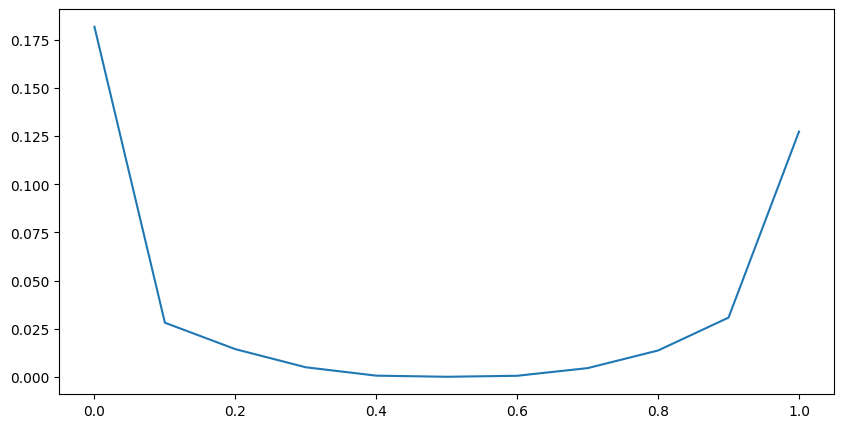

In [9]:
# График квантильной ошибки
quan_df = pd.DataFrame(quan, columns=['quantile error'])

index = np.arange(0, len(quan_df)*0.1, 0.1)
quan_df.set_index(index, inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(quan_df)
plt.show()

In [10]:
# Сохраняем названия столбцов из volatility_df
feature_names = volatility_df.columns[:-1]

# Получаем массив важностей признаков
importances = lgbm_model.feature_importances_

# Преобразуем массив в фрейм данных, чтобы сопоставить признаки с оригинальными столбцами
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Сортируем фрейм данных по важности признаков
importance_df = importance_df.sort_values('Importance', ascending=False)

importance_df['Importance, %'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100

print(importance_df)

         Feature  Importance  Importance, %
0  Recovered_vol        3048          100.0
